## Running OTVelo on scGEM

This script shows how to run OTVelo on scGEM. It is very similar to the other file Kouno-myVelo.ipynb but has more on temporal decomposition of the model at the end.

In [13]:
# load necessary modules
import numpy as np
import pandas as pd
import sys
sys.path.append('../Utils/')
from utils_Velo import *
#from agw_scootr import *
from utils import *
import scipy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The data for scGEM can be downloaded from the publication associated with scGEM:

Lih Feng Cheow, Elise T Courtois, Yuliana Tan, Ramya Viswanathan, Qiaorui Xing, Rui Zhen Tan, Daniel S Q Tan, Paul Robson, Loh Yuin-Han, Stephen R Quake, and William F Burkholder. Single-cell multimodal profiling reveals cellular epigenetic heterogeneity. Nature Methods, 13(10):833–836, 2016.

Link: https://www.nature.com/articles/nmeth.3961

The data can be found from source data to Fig.1



In [14]:
# Load data from xlsx file


df = pd.read_excel('../Data/41592_2016_BFnmeth3961_MOESM337_ESM.xlsx')
gene_names_all = list(df['Cell Stage'][4:38])
counts = df[4:38]



counts = np.array(counts)
counts = counts[:,1:]
counts = np.array(counts,dtype=float)

# There are 224 cells in total
for i in range(224):
    counts[:,i] = counts[:,i].T.reshape(1, -1) 

# Keep the branch that reprogrammed into IPS
group_labels = ['BJ','d8','d16T+','d24T+','IPS','ES']
Nt = len(group_labels)
stages = list(df.columns[1:])
groups = [[]]*Nt


idx_zeros = []
gene_names = []

for i in range(34):
    if np.max(counts[i,:] ) > 0:
        idx_zeros = idx_zeros + [i]
        gene_names = gene_names + [gene_names_all[i]]

counts = counts[idx_zeros,:]



for j in range(len(group_labels)):
    groups[j] = []
    for i in range(len(stages)):
    
        if stages[i][0:len(group_labels[j])] == group_labels[j]:
            groups[j] += [i]

          
counts_all = [[0]]*Nt

labels = np.zeros((1,counts.shape[1]))
num_start = 0
for j in range(len(group_labels)):
    counts_all[j] = []
    counts_all[j] = np.array(counts[:,groups[j]],dtype=float)
    num_end = num_start + len(groups[j])
    
    labels[0,num_start:num_end] = j
    
    num_start = num_end

labels = labels[:,0:num_end]

counts = counts_all[0]
for j in range(Nt-1):
    counts = np.concatenate( (counts, counts_all[j+1] ), axis=1 )



Compute the PCA and trajectory in cell space:

(33, 201)


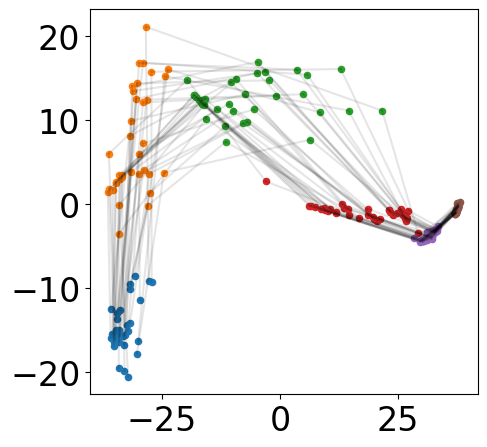

In [15]:
counts_pca, pca = visualize_pca(counts,labels,group_labels,viz_opt='pca')
n = counts.shape[0]
print(counts.shape)

eps_samp = 1e-2
eps_feat = 0

eps_track = [0]*9
counter = 0
solver = 'agw'

       
Ts_prior,_ = solve_prior(counts,counts, Nt, labels, eps_samp=eps_samp, alpha=0.5)
# Visualize cell path matched via OT
new_counts, new_counts_pca = visualize_cell_path(counts, counts_all, group_labels, Ts_prior )




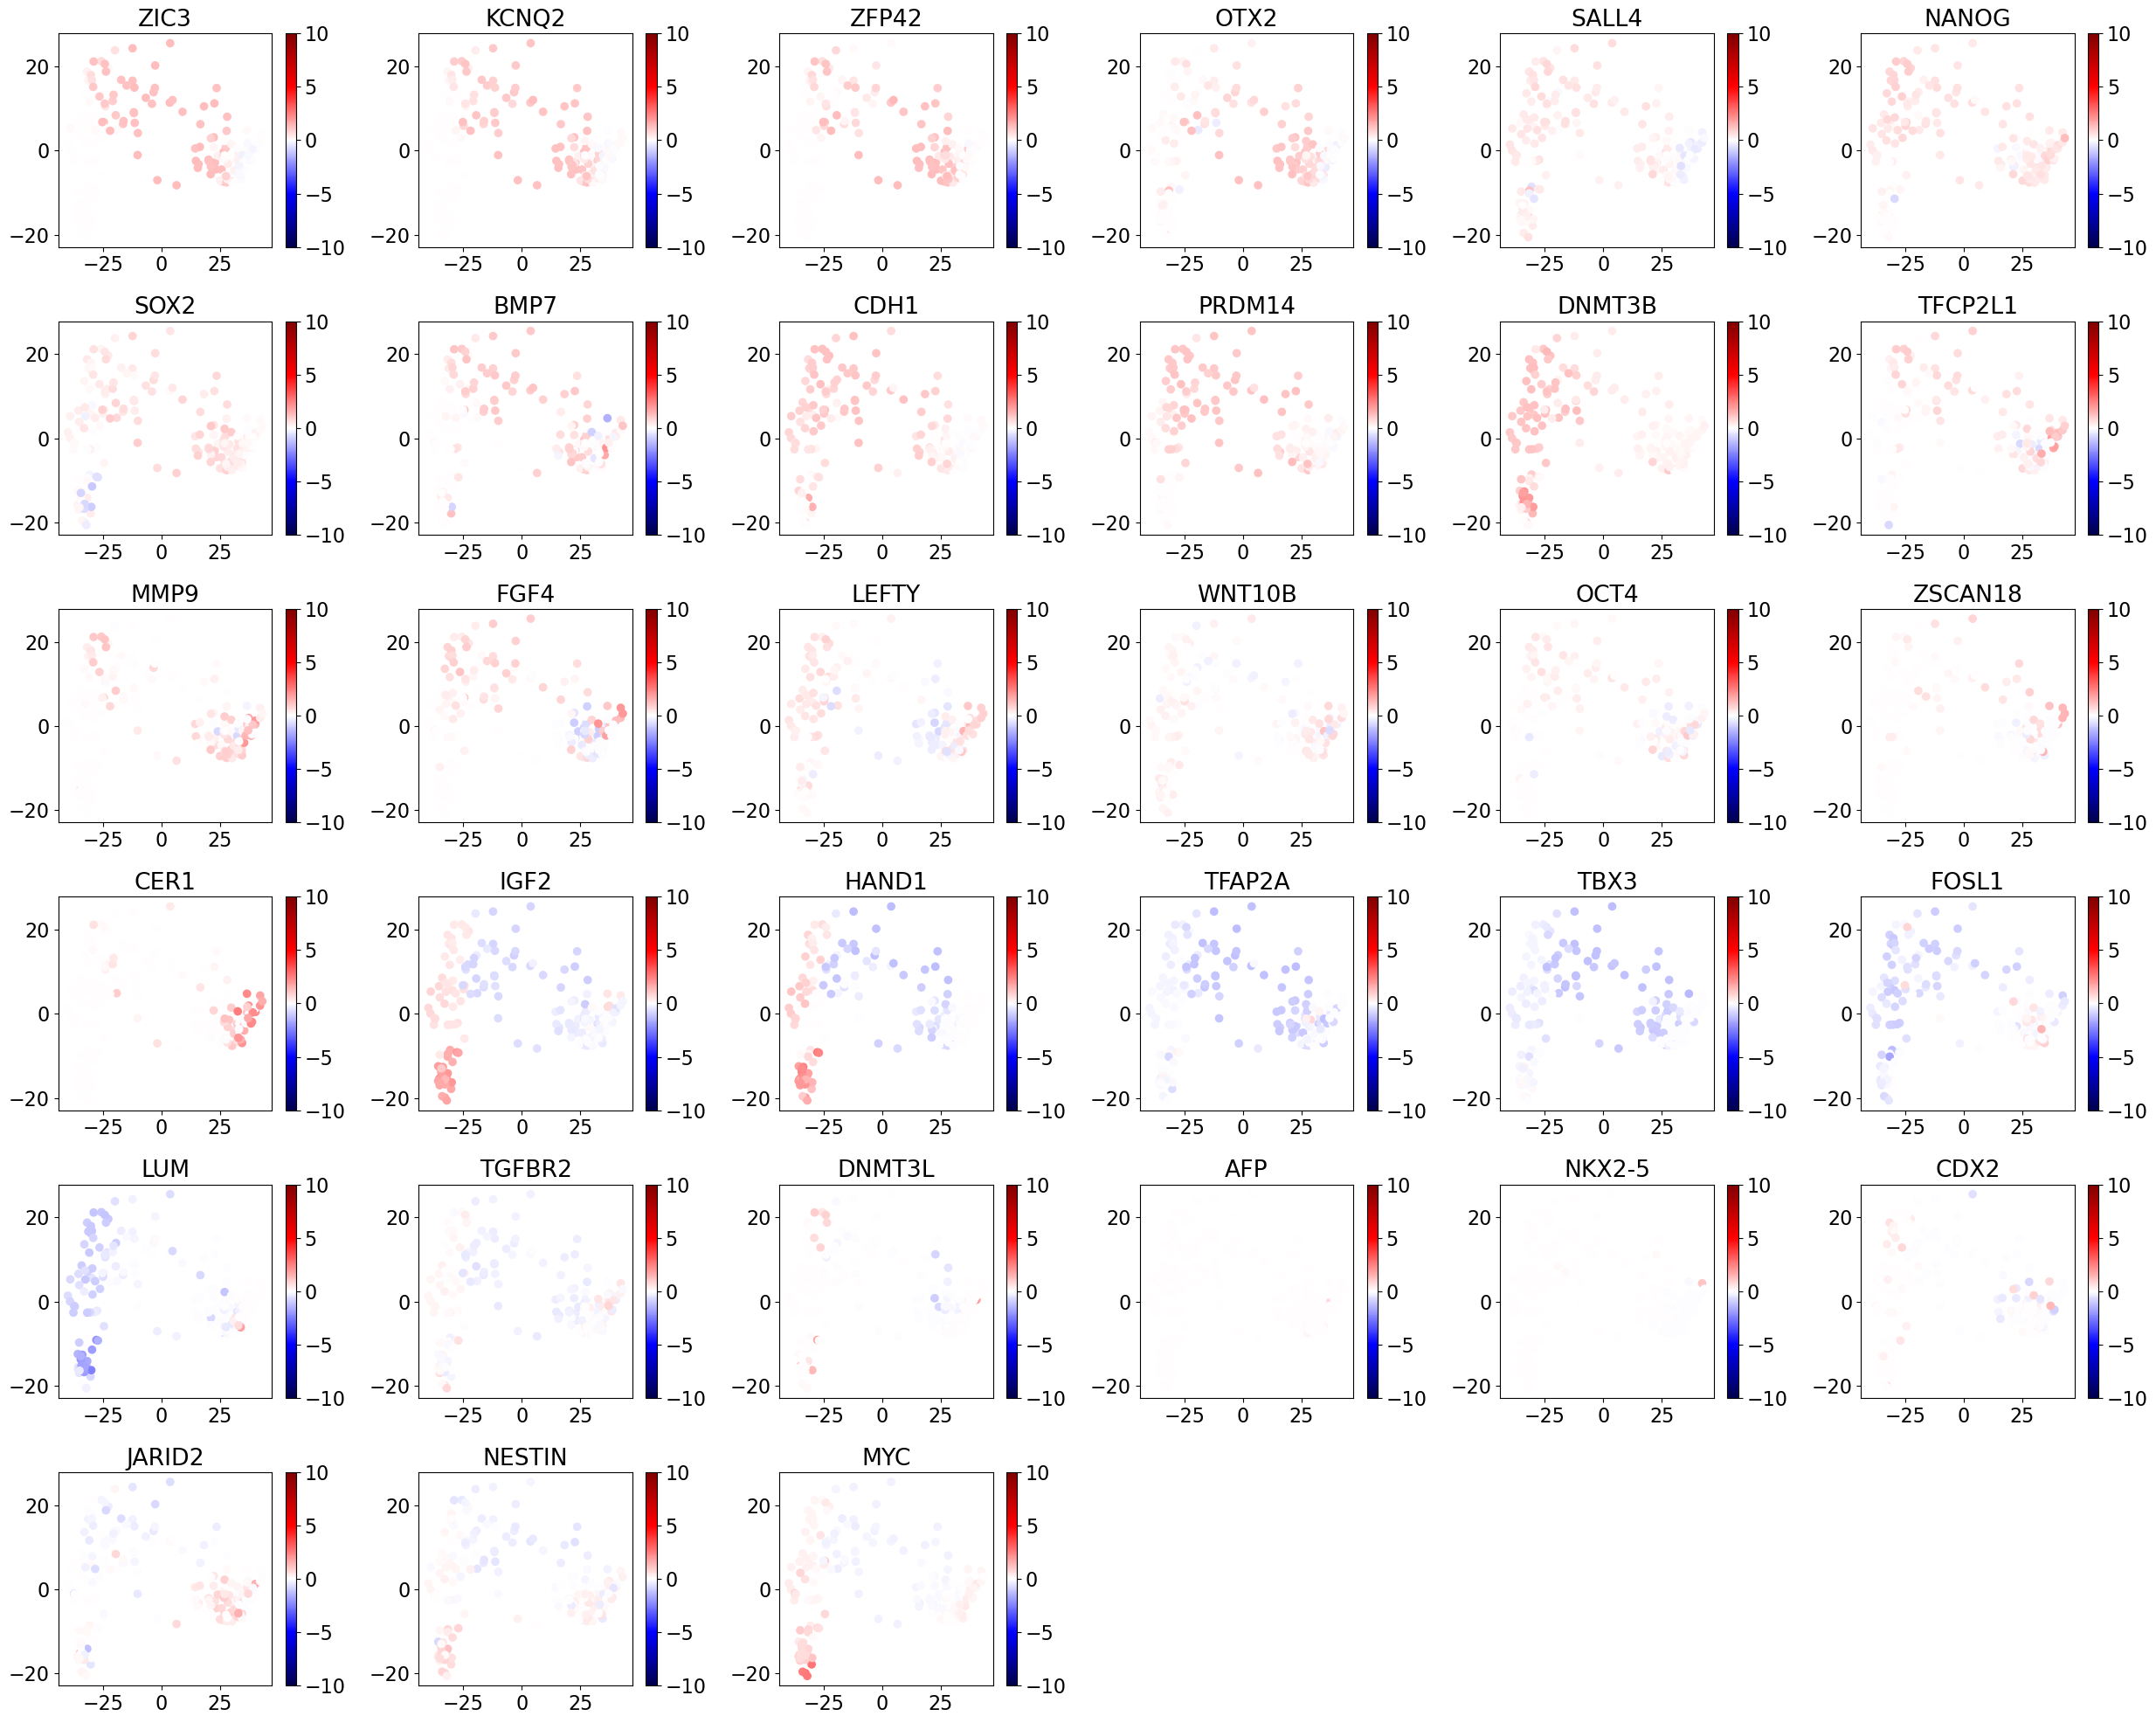

In [16]:
# The time points are uniformly separated by 8 days

dt = [8]*(Nt-1)

# Infer velocity
velocities_all, velocities_all_signed = solve_velocities( counts_all, Ts_prior, dt=dt)

# Visualize velocity for each gene
n = counts.shape[0]
plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (25,20)
for k in range(n):
    plt.subplot(6,6,k+1)
    for i in range(Nt):
        idx = np.where( labels == i )[1]
        plt.scatter( counts_pca[idx,0], counts_pca[idx,1], c = velocities_all_signed[i][k,:],cmap='seismic')
        plt.clim([-10,10])
    plt.colorbar()
    plt.title(gene_names[k])
plt.tight_layout()

Alternatively it can also be visualized as a big matrix. Blue suggests negative velocity/inhibition, and red suggests positive velocity/activation. The horizontal axis represents all cells, ordered according to time stamps.

From the plot below, we can already see the pattern in data -- initially the somatic genes (TFAP2A to LUM) are inhibited, while the intermediate genes (HAND1 and IGF2) are first activated and then inhibited. Finally, the pluripotency genes above are activated. The patterns of other genes are not significant.

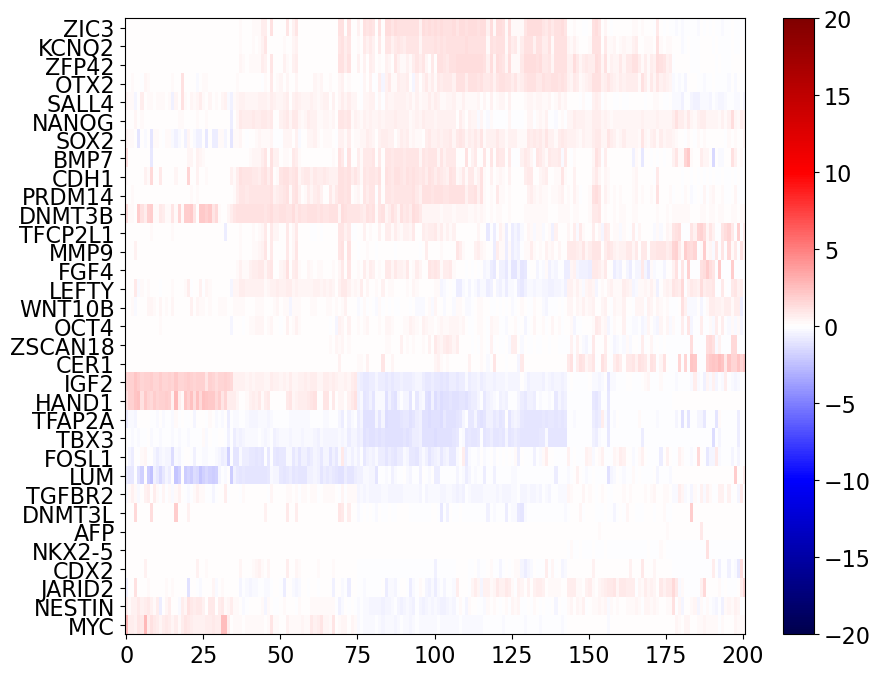

In [19]:
s = []
for i in range(Nt):
    s = s + [counts_all[i].shape[1]]
s_cum = list(np.cumsum(s))
s_cum = [0] + s_cum

# Concatenate velocity matrices...

plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (5,5)
n = counts_all[0].shape[0]
velocities = np.zeros( (n, counts.shape[1]))
velocities_signed = np.zeros( (n, (counts.shape[1])))

for i in range(Nt):
    
    velocities[:,s_cum[i]:s_cum[i+1] ] = velocities_all[i]
    velocities_signed[:,s_cum[i]:s_cum[i+1]] = velocities_all_signed[i]
    
# Visualize velocities as an overall matrix

plt.rcParams["figure.figsize"] = (10,8)
plt.imshow( velocities_signed, aspect='auto',cmap='seismic')
plt.yticks(range(n),gene_names)
plt.clim([-20,20])
plt.colorbar()

We can also validate if the velocity field captures the dynamics well. Below is a visualization of the velocity directions:

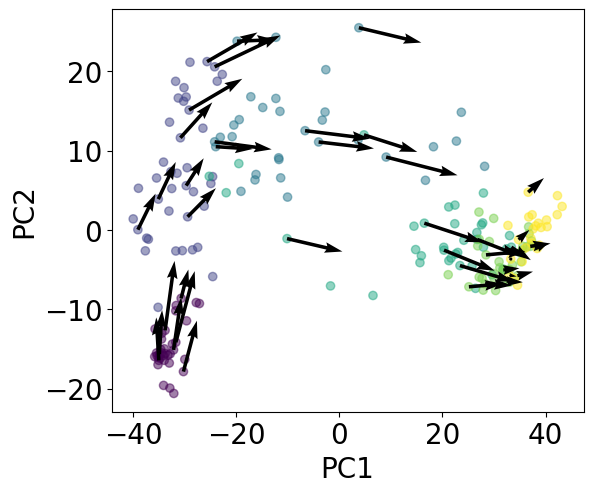

In [15]:
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["font.size"] = 20
velocities_all_pca = [ [0] ]*(Nt)

nums = []
for i in range(Nt):
    nums = nums + [ counts_all[i].shape[1] ]
      

i = 0
velocities_all[i] = [0]
count_t_mapped = nums[i]*np.matmul( counts_all[i+1],Ts_prior[i].T )
    
velocities_all_pca[i] = pca.transform( count_t_mapped.T ) - pca.transform( counts_all[i].T )


for i in range(1,Nt-1):
    velocities_all[i] = [0]
    count_t_mapped = np.matmul( counts_all[i+1],Ts_prior[i].T/np.sum(Ts_prior[i].T,axis=0) )
    
    velocities_all_pca[i] = (pca.transform( count_t_mapped.T ) - pca.transform( counts_all[i].T ) )/2
    count_t_mapped = np.matmul( counts_all[i-1],Ts_prior[i-1]/np.sum(Ts_prior[i-1],axis=0) )
    velocities_all_pca[i] = velocities_all_pca[i] + (pca.transform( counts_all[i].T ) - pca.transform( count_t_mapped.T ))/2
   
i = Nt-1

count_t_mapped = nums[i]*np.matmul( counts_all[i-1],Ts_prior[i-1] )
velocities_all_pca[i] = pca.transform(counts_all[i].T) - pca.transform( count_t_mapped.T )

velocities_pca = np.zeros( ( n, s_cum[-1]))

for i in range(Nt):
    
    velocities_pca[:,s_cum[i]:s_cum[i+1]] = velocities_all_pca[i].T


plt.scatter(counts_pca[:,0], counts_pca[:,1],c=labels, alpha=0.5 )
# plt.colorbar()
# velocities_pca = pca.transform( velocities_signed.T)
Num_cell = s_cum[-1]
idx_subsamp = range(0,Num_cell,5)
plt.quiver( counts_pca[idx_subsamp,0],counts_pca[idx_subsamp,1],velocities_pca[0,idx_subsamp] , velocities_pca[1,idx_subsamp], scale=200 )
plt.tight_layout()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
#plt.savefig('../Results/scGEM/velocity_scGEM.pdf',dpi=1000)




Now we are ready to run the algorithm for GRN inference

In [25]:
# OTVelo-Corr
Tv_corr, Tv_corr_slice = OT_lagged_correlation(velocities_all_signed, velocities_signed, Ts_prior, return_slice=True)

# OTVelo-Granger
Tv_granger, Tv_granger_slice = OT_lagged_correlation(velocities_all_signed, velocities_signed, Ts_prior, elastic_Net=True, l1_opt=0.5, signed=True, return_slice=True )

/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

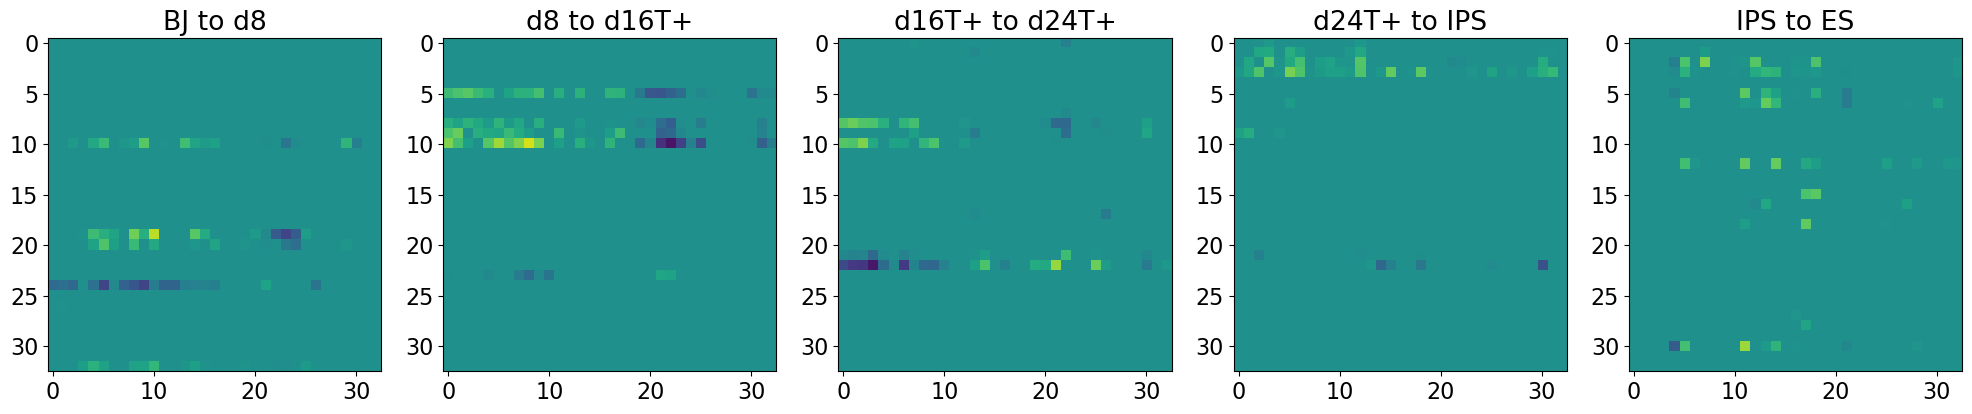

In [28]:
# Visualize weight matrices by time points
plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (20,20)
n = counts.shape[0]

for i in range(Nt-1):

        
    plt.subplot(1,Nt-1,i+1)
        
        
    plt.imshow(Tv_granger_slice[i] -np.diag( np.diag(Tv_granger_slice[i])) )#- np.diag( np.diag( Tv[counter][i])) )
    plt.title(group_labels[i]+' to '+group_labels[i+1] )
    plt.clim([-0.5,0.5])
plt.tight_layout()
plt.show()
  

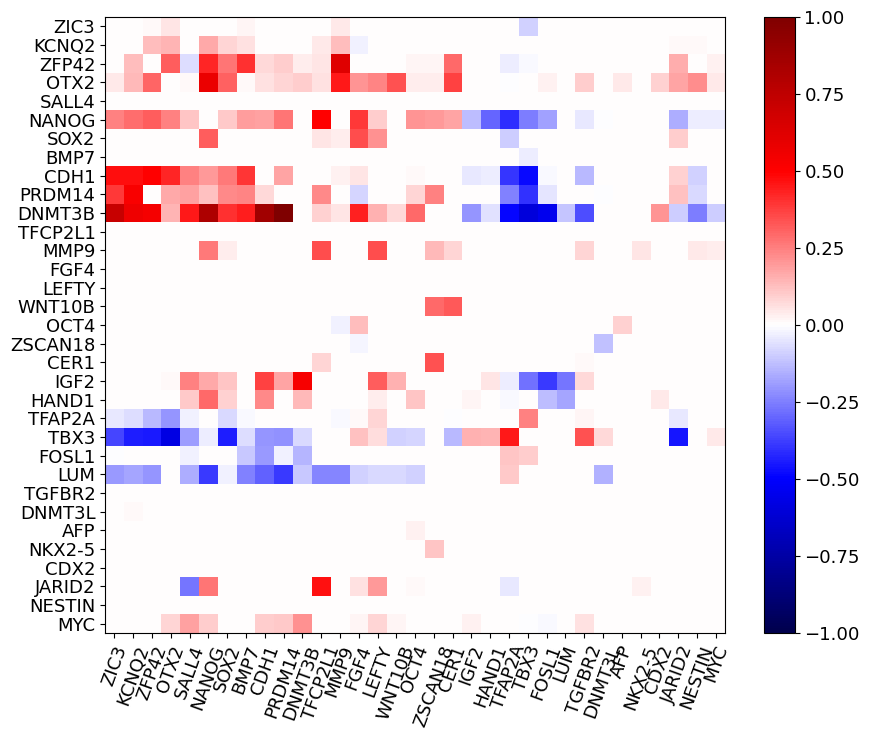

In [27]:
Tv_total = Tv_granger
plt.rcParams["font.size"] = 13
plt.rcParams["figure.figsize"] = (10,8)

Tv_total = Tv_total - np.diag( np.diag( Tv_total) )
Tv_total = Tv_total / abs(Tv_total).max()

plt.imshow(Tv_total,aspect='auto',cmap='seismic')
plt.xticks(range(n),gene_names,rotation=70)
plt.yticks(range(n),gene_names)
plt.clim([-1,1])
plt.colorbar()
